In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils import shuffle
%matplotlib inline
# tf crash fix
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
df = pd.read_csv("../ready_data/winter_2021.csv")

In [3]:
def create_target_bin(row):
    if 0.4 < row["Friction"] <= 0.6:
        return 2
    elif 0.2 < row["Friction"] <= 0.4:
        return 1
    elif row["Friction"] <= 0.2:
        return 0
    elif row["Friction"] > 0.6:
        return 3

In [4]:
df["friction_class"] = df.apply(create_target_bin, axis=1)


In [5]:
# Using MinMax scaler to scale relevant variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale only relevant variables
num_cols = ['airTemp', 'humidity', 'dewpoint', 'Friction',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm']
df[num_cols] = scaler.fit_transform(df[num_cols])




In [6]:
df["sequence"] = df.index + 1
df = df.drop("ts", axis = 1)



In [7]:
# Shift values of friction calss to 12 points back,
# by that we get a forecast of friction in 2 hours and can make a decision is going up or down
df['friction_class'] = df['friction_class'].shift(periods=-12)
df = df.dropna()



In [8]:
# To get the number of variables
n_features = len(num_cols)
n_classes = len(df["friction_class"].unique())

In [9]:
timestep_size = 36

input_windows = sliding_window_view(df[num_cols].values, window_shape=(timestep_size, n_features))[::timestep_size]

target_windows = sliding_window_view(df['friction_class'].values, window_shape=(timestep_size))[::timestep_size]
targets = target_windows[:,-1]

inputs = input_windows.reshape(-1,timestep_size, n_features)

X= inputs
y = targets

X,y = shuffle(X,y, random_state=42)

In [10]:
 # define the cutoff point
train_size = 0.8
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [11]:
import keras 

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),

            keras.layers.Conv1D(filters=32, kernel_size=2, padding="same", activation="relu", kernel_regularizer=keras.regularizers.L2(l2=0.1)),

            keras.layers.Conv1D(filters=16, kernel_size=1, padding="same", activation="relu", kernel_regularizer=keras.regularizers.L1(l1=0.1)),
            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(16, activation="relu"),
            # output layer
            keras.layers.Dense(n_classes, activation="softmax")
        ]
    )

    return model


# make the model
model = make_model(input_shape=x_train.shape[1:])

In [12]:
epochs = 1000
batch_size = 128

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "CNN.keras", save_best_only=True, monitor="sparse_categorical_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="sparse_categorical_accuracy", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
) 


Epoch 1/1000


4/4 [==============================] - 1s 17ms/step - loss: 15.0174 - sparse_categorical_accuracy: 0.0124 - lr: 0.0010
Epoch 2/1000
4/4 [==============================] - 0s 11ms/step - loss: 14.5099 - sparse_categorical_accuracy: 0.1224 - lr: 0.0010
Epoch 3/1000
4/4 [==============================] - 0s 11ms/step - loss: 14.0344 - sparse_categorical_accuracy: 0.4129 - lr: 0.0010
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 13.5816 - sparse_categorical_accuracy: 0.4336 - lr: 0.0010
Epoch 5/1000
4/4 [==============================] - 0s 4ms/step - loss: 13.1456 - sparse_categorical_accuracy: 0.4336 - lr: 0.0010
Epoch 6/1000
4/4 [==============================] - 0s 4ms/step - loss: 12.7223 - sparse_categorical_accuracy: 0.4336 - lr: 0.0010
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 12.3145 - sparse_categorical_accuracy: 0.4336 - lr: 0.0010
Epoch 8/1000
4/4 [==============================] - 0s 3ms/step - loss: 11.9

In [13]:
model = keras.models.load_model("CNN.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

4/4 [==============================] - 0s 2ms/step - loss: 0.6853 - sparse_categorical_accuracy: 0.8347
Test accuracy 0.8347107172012329
Test loss 0.6852759718894958


In [14]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

4/4 [==============================] - 0s 2ms/step


<Axes: >

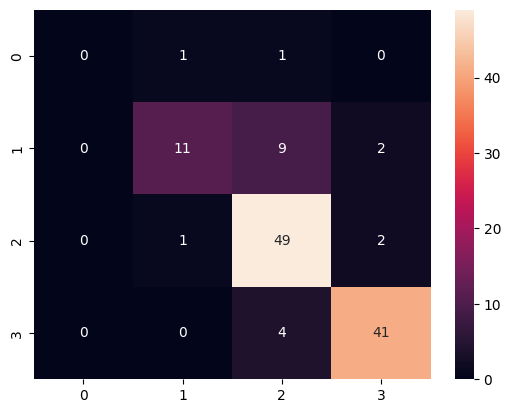

In [15]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

# pretty decent, most of the cases of non-slippery
# and slippery was correctly detected

In [16]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.85      0.50      0.63        22
         2.0       0.78      0.94      0.85        52
         3.0       0.91      0.91      0.91        45

    accuracy                           0.83       121
   macro avg       0.63      0.59      0.60       121
weighted avg       0.83      0.83      0.82       121


Model overall accuracy: 83.47%


c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [17]:
forecast_steps = 12

test_df = pd.read_csv("../ready_data/test_day.csv")
test = test_df[:-forecast_steps]
sequence = test[-37:]

input_windows = sliding_window_view(sequence[num_cols].values, window_shape=(timestep_size, n_features))[::timestep_size]
last_input = input_windows.reshape(-1,timestep_size, n_features)

In [18]:
future_predictions = []
for _ in range(forecast_steps):
    next_pred = model.predict(last_input)  # Predict the next time step
    # Extract the predicted class with the highest probability (using argmax)
    predicted_class = np.argmax(next_pred, axis=1)  # Get the class with the highest probability
    print("Most probable class: ", predicted_class)
    future_predictions.append(next_pred)  # Append the prediction to the list
    # Update the sequence by adding the predicted value and removing the oldest value
    last_input = np.roll(last_input, shift=-1, axis=1)
    last_input[0, -1, 0] = predicted_class[0]


1/1 [==============================] - 0s 22ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 16ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 18ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 18ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 22ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 19ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 18ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 19ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 16ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 17ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 19ms/step
Most probable class:  [1]
1/1 [==============================] - 0s 46ms/step
Most probable class:  [1]


In [19]:
print(future_predictions)

[array([[0.05092331, 0.77047175, 0.17360044, 0.0050046 ]], dtype=float32), array([[0.05092329, 0.77047145, 0.17360067, 0.00500461]], dtype=float32), array([[0.0509233 , 0.77047104, 0.17360108, 0.00500462]], dtype=float32), array([[0.05092328, 0.7704706 , 0.17360148, 0.00500463]], dtype=float32), array([[0.05092327, 0.7704701 , 0.17360194, 0.00500463]], dtype=float32), array([[0.05092326, 0.7704697 , 0.17360234, 0.00500465]], dtype=float32), array([[0.05092327, 0.77046925, 0.17360283, 0.00500466]], dtype=float32), array([[0.05092325, 0.7704689 , 0.1736032 , 0.00500467]], dtype=float32), array([[0.05092327, 0.7704684 , 0.17360365, 0.00500468]], dtype=float32), array([[0.05092326, 0.77046806, 0.17360403, 0.00500469]], dtype=float32), array([[0.05092325, 0.7704676 , 0.17360449, 0.0050047 ]], dtype=float32), array([[0.05092323, 0.7704671 , 0.17360488, 0.00500471]], dtype=float32)]
